In [1]:
import os, glob
import math, copy, time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from tqdm import tqdm, trange

import numpy as np

import matplotlib
from matplotlib import pyplot as plt

from IPython.display import HTML
from IPython.display import display

from skeleton_models import ntu_rgbd, ntu_ss_1, ntu_ss_2, ntu_ss_3
from graph import Graph
from render import animate

# Model components
from datasets import NTUBasicDataset, Normalize, CropSequence, SelectDimensions, SelectSubSample

from zoo_pose_embedding import TwoLayersGCNPoseEmbedding, JoaosDownsampling
from zoo_action_encoder_units import TransformerEncoderUnit
from zoo_action_decoder_units import TransformerDecoderUnit
from zoo_upsampling import StepByStepUpsampling, JoaosUpsampling
from model import ActionEmbeddingTransformer, LetsMakeItSimple
from layers import subsequent_mask



Shape = (83, 25, 3)


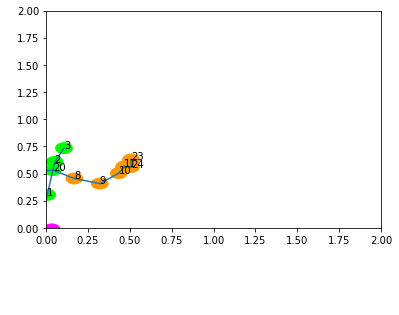

In [2]:
sample_data1 = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P008R002A023.skeleton.npy', allow_pickle=True)[()]
sample_data2 = np.load('../datasets/NTURGB-D/Python/raw_npy/S003C001P016R001A023.skeleton.npy', allow_pickle=True)[()]
sequence1 =  sample_data1['skel_body0']
sequence2 =  sample_data2['skel_body0']
print('Shape = {}'.format(sequence1.shape))
animate(sequence1 - sequence1[0,0], ntu_rgbd)

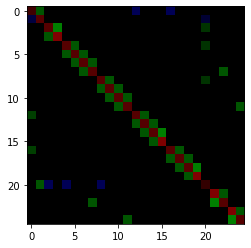

In [3]:
adjacency = Graph(ntu_rgbd)
plt.imshow(adjacency.A.transpose(1,2,0)[:,:,0:3])

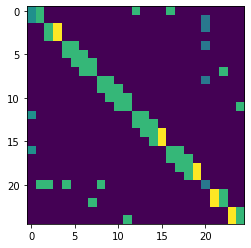

In [4]:
plt.imshow(adjacency.A.sum(axis=0))

In [5]:
adjacency.A.shape

(3, 25, 25)

In [6]:
skeleton_model = ntu_rgbd
adjacency = Graph(skeleton_model)
conf_kernel_size = adjacency.A.shape[0]
conf_num_nodes = adjacency.A.shape[1]
conf_heads = 5
conf_encoding_per_node = 100
conf_internal_per_node = int(conf_encoding_per_node/conf_heads)
print(conf_encoding_per_node*conf_num_nodes)


class BetterThatBestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = ActionEmbeddingTransformer(
            JoaosDownsampling(
                conf_num_nodes,
                conf_encoding_per_node*conf_num_nodes,
                node_channel_in = 2,
                device=device
            ),
            TransformerEncoderUnit (
                heads=conf_heads,
                embedding_in=conf_num_nodes*conf_encoding_per_node,
                embedding_out=conf_num_nodes*conf_internal_per_node
            ),
            TransformerDecoderUnit(
                heads=conf_heads,
                embedding_in=conf_num_nodes*conf_encoding_per_node,
                embedding_out=conf_num_nodes*conf_internal_per_node,
                memory_in=conf_num_nodes*conf_encoding_per_node
            ),
            JoaosUpsampling(
                conf_num_nodes,
                conf_encoding_per_node*conf_num_nodes,
                node_channel_out = 2,
                device=device
            )
        )

    def forward(self, x_in, x_out, A, mask):
        return self.model(x_in, x_out, A, mask)
    


2500


In [30]:
class LetsMakeItSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.pose_embedding = JoaosDownsampling(
            conf_num_nodes,
            conf_encoding_per_node*conf_num_nodes,
            node_channel_in = 2,
            device=device
        )
        self.transformers = nn.Transformer(
            nhead=5, 
            d_model=conf_encoding_per_node*conf_num_nodes, 
            num_encoder_layers=3, 
            num_decoder_layers=3
        )
        self.upsampling =JoaosUpsampling(
            conf_num_nodes,
            conf_encoding_per_node*conf_num_nodes,
            node_channel_out = 2,
            device=device
        )
    def forward(self, x_in, x_out, A, mask):

        pe_in = self.pose_embedding(x_in, A)    # [N, Tin, V, Co] -> [N, Tin, V*C]
        pe_out = self.pose_embedding(x_out, A)  # [N, Tout, V, Co] -> [N, Tout, V*C]
        pe_in = pe_in.permute(1, 0, 2)
        pe_out = pe_out.permute(1, 0, 2)
        print(pe_in.size())
        print(pe_out.size())
        decoded = self.transformers(pe_in, pe_out)
        #encoded = self.action_encoder(pe_in, A) # [N, Tin, V*C] -> [N, Tin, V*C]
        #decoded = self.action_decoder(pe_out, encoded, A, mask) # [N, Tin, V*C] [N, Tout, V*C] [K, V, V] [1, Tout, Tout] -> # [N, Tout, V*C]
        decoded = decoded.permute(1, 0, 2)
        output = self.upsampling(decoded)       # [N, Tout, V*C] -> [N, Tout, V, Co]

        return output
        

In [17]:
new_wave = LetsMakeItSimple()

Warn: not activated
Warn: not activated


In [7]:
print(sequence2.shape)

X = torch.from_numpy(sequence2).float().permute(2, 0, 1).unsqueeze(0)
A = torch.from_numpy(adjacency.A).float()
print(X.size())
print(A.size())

(59, 25, 3)
torch.Size([1, 3, 59, 25])
torch.Size([3, 25, 25])


In [8]:
class NTUProblem1Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform #root_dir
        self.files = glob.glob(root_dir+'*C001*.npy')
        print('Num files = {}'.format(len(self.files)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_data = np.load(self.files[idx], allow_pickle=True)[()]
        nodes_off = [6, 7, 10, 11, 14, 15, 18, 19]
        base_data =  file_data['skel_body0']
        if self.transform:
            base_data = self.transform(base_data)

        encoder_input = np.copy(base_data[:-1,:,:])
        encoder_input[:, nodes_off, :] = 0

        decoder_input = np.copy(np.roll(encoder_input, 1, axis=0)[0:2])
        decoder_input[0, :, :] = 0

        ground_truth = np.copy(base_data[0:2,:,:])

        # Shape = (n, t, v, c)

        return encoder_input, decoder_input, ground_truth

    
    
composed = transforms.Compose([Normalize(),
                               SelectDimensions(2),
                               SelectSubSample(skeleton_model)
                              ])
    
ntu_dataset = NTUProblem1Dataset(root_dir='../datasets/NTURGB-D/Python/raw_npy/', transform=composed)
ei, di, gt = ntu_dataset[1]
print(ei.shape)
print(di.shape)
print(gt.shape)

t, v, c = di.shape

print(subsequent_mask(t))

Num files = 18932
(58, 25, 2)
(2, 25, 2)
(2, 25, 2)
tensor([[[ True, False],
         [ True,  True]]])


In [9]:
device='cpu'

def collate_triple(batch):
    eis = list(map(lambda x: x[0], batch))
    dis = list(map(lambda x: x[1], batch))
    gts = list(map(lambda x: x[2], batch))
    
    eis_lengths = list(map(lambda x: x.shape[0], eis))
    dis_lengths = list(map(lambda x: x.shape[0], dis))
    gts_lengths = list(map(lambda x: x.shape[0], gts))
    
    min_eis = min(eis_lengths)
    min_dis = min(dis_lengths)
    min_gts = min(gts_lengths)
    eis = np.array(list(map(lambda x: x[:min_eis], eis)))
    dis = np.array(list(map(lambda x: x[:min_dis], dis)))
    gts = np.array(list(map(lambda x: x[:min_gts], gts)))
    
    if len(batch) == 0:
        raise Exception("No sample on batch")
    
    print('({} {} {})'.format(min_eis, min_dis, min_gts))
    return torch.from_numpy(eis), torch.from_numpy(dis), torch.from_numpy(gts)


#model = BetterThatBestModel()
model = LetsMakeItSimple(device, conf_num_nodes, conf_encoding_per_node)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

criterion = torch.nn.MSELoss()



loader = DataLoader(ntu_dataset, batch_size=100, shuffle=True, collate_fn=collate_triple)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)

#print()

for epoch in range(20):
    pbar = tqdm(loader, desc='Initializing ...')
    for ei, di, gt in pbar:
        ei = ei.float()
        di = di.float()
        gt = gt.float()
        n, t, v, c = di.size() 
        out = model(ei, di, A, subsequent_mask(t))
        
        loss = criterion(out, gt)
        loss.backward()

        # update parameters
        optimizer.step()
        pbar.set_description("Curr loss = {:.4f}".format(loss.item()))
    
    
    

Warn: not activated
Warn: not activated


Initializing ...:   0%|          | 0/190 [00:00<?, ?it/s]

(35 2 2)


Curr loss = 0.5567:   1%|          | 1/190 [00:38<2:00:57, 38.40s/it]

(37 2 2)


Curr loss = 0.5567:   1%|          | 1/190 [01:11<3:46:22, 71.86s/it]


KeyboardInterrupt: 

In [ ]:
partial3[0].permute(1,2,0).size()
animate(partial3[0].permute(1,2,0), ntu_ss_3)

In [ ]:
labels3[0].permute(1,2,0).size()
animate(labels3[0].permute(1,2,0), ntu_ss_3)